In [1]:
import numpy as np
import pandas as pd
import os
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import re
import sys
#!pip install git+https://github.com/shijianjian/EfficientNet-PyTorch-3D
#!pip install torch-summary
import cv2

In [2]:
files = glob.glob('/kaggle/working/*')
for f in files:
    os.remove(f)

In [3]:
sys.path.append("../input/efficientnetpyttorch3d/EfficientNet-PyTorch-3D")

In [4]:
#Organisers have said these are to be ignored
exclude = [109, 123, 709]
train_csv = pd.read_csv('/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv')
train_csv = train_csv[~train_csv.BraTS21ID.isin(exclude)]

<AxesSubplot:xlabel='MGMT_value', ylabel='count'>

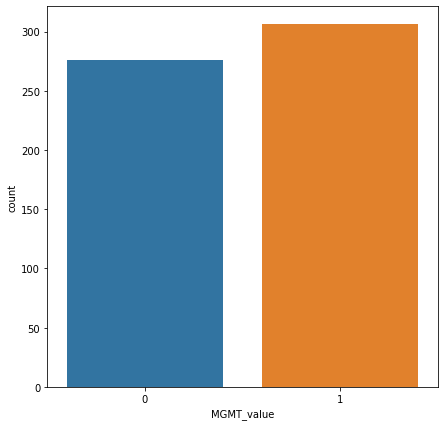

In [5]:
plt.figure(figsize=(7, 7))
sns.countplot(data=train_csv, x="MGMT_value")

In [6]:
NUM_IMAGES = 64
mri_types = ['FLAIR','T1w','T1wCE','T2w']
SIZE = 260

#https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way

def load_dicom(path, voi_lut = True, fix_monochrome = True, augment=False, rotation_choice=0):
    dicom = pydicom.read_file(path)
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
    # MONOCHROME1 means that the brightness decreases as the value increases
    # This would lead to inverted images, so we reverse this
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    
    if augment:
        rotation_choices = [0, cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_90_COUNTERCLOCKWISE, cv2.ROTATE_180]
        
        rotation = rotation_choices[rotation_choice]
        data = cv2.rotate(data, rotation)
    
    data = cv2.resize(data, (SIZE, SIZE))
    data = data.astype(np.float64)
    return data

#loads 64 (SIZE) images from a DICOM file from a single MRI type
def load_dicom_3d(brats21id, mri_type, num_imgs=NUM_IMAGES, img_size=SIZE, data_split="train", augment=False):
    patient_path = os.path.join(f"/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/{data_split}/", str(brats21id).zfill(5))
    x = glob.glob(os.path.join(patient_path, mri_type, "*"))
    paths = sorted(x, key=lambda x: int(x[:-4].split("-")[-1]))
    middle = len(paths) // 2
    num_imgs2 = num_imgs // 2
    bottom = max(0, middle - num_imgs2)
    top = min(len(paths), middle + num_imgs2)
    
    rotation_choice = 0
    if augment:
        rotation_choice = np.random.randint(0,4)
        
    image_3d = np.stack([load_dicom(f, augment=augment, rotation_choice=rotation_choice) for f in paths[bottom:top]]).transpose()
    
    if image_3d.shape[-1] < num_imgs:
        zero_padding = np.zeros((img_size, img_size, abs(num_imgs - image_3d.shape[-1])))
        image_3d = np.concatenate((image_3d, zero_padding), axis=-1)
    
    #normalise data
    if np.min(image_3d) < np.max(image_3d):
        image_3d = image_3d - np.min(image_3d)
        image_3d = image_3d / np.max(image_3d)
    return np.expand_dims(image_3d, 0)

In [7]:
a = load_dicom_3d(9, "T1wCE")
print(a.shape)
print(np.min(a), np.max(a), np.mean(a), np.median(a))

(1, 260, 260, 64)
0.0 1.0 0.05689695408977306 0.00010092854259183485


In [8]:
# Displays the middle sample of each MRI type for an ID
def visualise_sample(brats21id, mgmt_value, types=("FLAIR", "T1w", "T1wCE", "T2w")):
    plt.figure(figsize=(16, 5)) 
    patient_path = os.path.join("/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train/", str(brats21id).zfill(5))
    for i, type in enumerate(types, 1):
        x = glob.glob(os.path.join(patient_path, type, "*"))
        type_paths = sorted(glob.glob(os.path.join(patient_path, type, "*")), key=lambda x: int(x[:-4].split("-")[-1]))
        data = load_dicom(type_paths[(len(type_paths) // 2)])
        plt.subplot(1, 4, i)
        plt.imshow(data, cmap="gray")
        plt.title(f"{type}", fontsize=16)

    plt.suptitle(f"BraTS21ID: {brats21id}  MGMT_value: {mgmt_value}", fontsize=16)
    plt.show()

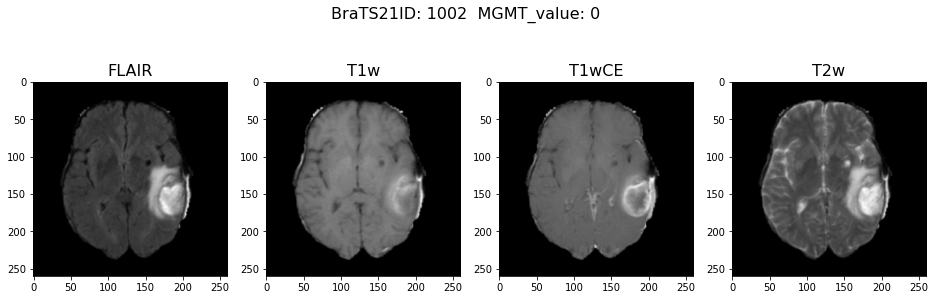

In [9]:
random_sample = train_csv.sample(n=1).values
random_sample_ID = random_sample[0][0]
random_sample_MGMT = random_sample[0][1]
visualise_sample(1002, random_sample_MGMT)

In [10]:
from efficientnet_pytorch_3d import EfficientNet3D
from efficientnet_pytorch_3d.utils import Conv3dStaticSamePadding

import torch
from torch import nn
torch.set_default_dtype(torch.float64)

#dataset splitting
from sklearn import model_selection as sk_model_selection

#convolutional
from torch.nn import functional as torch_functional

In [11]:
train, valid = sk_model_selection.train_test_split(train_csv, random_state=3220, stratify=train_csv["MGMT_value"],)
valid

,BraTS21ID,MGMT_value
215,313,1
582,1008,1
112,167,0
28,45,0
230,334,1
...,...,...
85,132,0
290,419,0
180,267,0
281,408,1


In [12]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, image_IDs, targets=None, mri_type=None, split="train", augment=False):
        self.image_IDs = image_IDs
        self.targets = targets
        self.mri_type = mri_type
        self.split = split
        self.augment = augment
        
    def __len__(self):
        return len(self.image_IDs)
    
    def __getitem__(self, i: int):
        image_num = self.image_IDs[i]
        #targets is None when testing
        if self.targets is not None:
            data = load_dicom_3d(image_num, self.mri_type, augment=self.augment)
        else:
            data = load_dicom_3d(image_num, self.mri_type, data_split=self.split, augment=self.augment)
        
        if self.targets is not None:
            return {"X": data, "y": torch.tensor(self.targets[i], dtype=torch.float64)}
        else:
            return {"X": torch.tensor(data, dtype=torch.float64), "id": image_num}

In [13]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        #create a network using efficientnet-b0, that has 2 output classes (MGMT 1/0) and 1 input channel as it is greyscale
        self.network = EfficientNet3D.from_name("efficientnet-b3", override_params={'num_classes': 2}, in_channels=1)
        #classifier
        self.network._fc = nn.Linear(in_features=self.network._fc.in_features, out_features=1, bias=True)
        
    def forward(self, x):
        out = self.network(x)
        return out

In [14]:
import time
from sklearn.metrics import roc_auc_score
class Trainer:
    def __init__(self, model, device, optimizer, criterion):
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.criterion = criterion
        self.output_model = None
        self.best_auc = 0
        
    def fit(self, epochs, train_loader, valid_loader, path):
        all_training_losses = []
        all_valid_losses = []
        all_auc = []
        for epoch_n in range(1, epochs + 1):
            print(f"Epoch {epoch_n}")
            train_loss = self.train_one_epoch(train_loader)
            valid_loss, auc = self.validate_one_epoch(valid_loader)
            all_training_losses.append(train_loss)
            all_valid_losses.append(valid_loss)
            all_auc.append(auc)
            print("Training loss: ", train_loss)
            print("Validation loss: ", valid_loss)
            if auc > self.best_auc:
                self.save_model(path, valid_loss, auc)
                self.best_auc = auc
        return all_training_losses, all_valid_losses, all_auc
                    
    def train_one_epoch(self, train_dataloader):
        sum_losses = 0
        self.model.train()
        time_start = time.time()
        for step, batch in enumerate(train_dataloader, 1):
            print("Step: ", step, end='\r')
            ids = batch["X"].to(self.device)
            targets = batch["y"].to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(ids).squeeze(1)
            
            loss = self.criterion(outputs, targets)
            loss.backward()

            sum_losses += loss.detach().item()

            self.optimizer.step()
        print(time.time() - time_start)
        average_loss = sum_losses/len(train_dataloader)
        return average_loss

    
    def validate_one_epoch(self, valid_dataloader):
        #set model up for evaluation, disables dropout layers etc.
        self.model.eval()
        sum_losses = 0
        all_outputs = []
        all_targets = []
        time_start = time.time()
        for step, batch in enumerate(valid_dataloader, 1):
            #deactivate autograd
            with torch.no_grad():
                X = batch["X"].to(self.device)
                targets = batch["y"].to(self.device)
                
                outputs = self.model(X).squeeze(1)
                loss = self.criterion(outputs, targets)
                
                sum_losses += loss.detach().item()
                all_targets.extend(batch["y"].tolist())
                all_outputs.extend(torch.sigmoid(outputs).tolist())
                
        for x in all_targets:
            if x > 0.5:
                x = 1
            else:
                x = 0

        auc = roc_auc_score(all_targets, all_outputs)
        print("Time: ", time.time() - time_start, "AUC: ", auc)
        average_loss = sum_losses/len(valid_dataloader) 
        return average_loss, auc

    def save_model(self, path, loss, auc):
        self.output_model = f"{path}_{loss:.2f}_{auc:.2f}.pt"
        print(f"Saving {self.output_model}")
        torch.save(self.model.state_dict(), self.output_model)

In [15]:
#from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def train_model(train, valid, mri_type):
    train_dataset = Dataset(
        train["BraTS21ID"].values,
        train["MGMT_value"].values,
        mri_type=mri_type,
        split="train",
        augment=True
    )

    train_loader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=4,
            shuffle=True,
            num_workers=2,pin_memory = True
    )
    
    valid_dataset = Dataset(
        valid["BraTS21ID"].values,
        valid["MGMT_value"].values,
        mri_type=mri_type,
        split="train"
    )

    valid_loader = torch.utils.data.DataLoader(
            valid_dataset,
            batch_size=4,
            shuffle=True,
            num_workers=2,pin_memory = True
    )
    
    model = Model()
    model.to(device)
    #summary(model, input_size=(1, 256, 256, 64))
    optimiser = torch.optim.AdamW(model.parameters(), lr=0.001)
    criterion = torch_functional.binary_cross_entropy_with_logits

    trainer = Trainer(model, device, optimiser, criterion)
    epochs = 10
    history = trainer.fit(epochs, train_loader, valid_loader, mri_type)
    train_losses = history[0]
    valid_losses = history[1]
    aucs = history[2]
    
    epochs = list(range(1, epochs + 1))
    
    fig, axs = plt.subplots(1, 3)
    fig.suptitle(f"AUC and loss values over 10 epochs ({mri_type})")
    fig.tight_layout()
    
    axs[0].plot(epochs, aucs)
    axs[0].set_title("AUC")
    axs[1].plot(epochs, train_losses)
    axs[1].set_title("Training loss")
    axs[2].plot(epochs, valid_losses)
    axs[2].set_title("Validation loss")
    
    return trainer.output_model

Epoch 1
214.9275393486023
Time:  65.19712138175964 AUC:  0.5027291549030679
Training loss:  0.7595470994089423
Validation loss:  0.7248199161165427
Saving FLAIR_0.72_0.50.pt
Epoch 2
168.46913623809814
Time:  49.77296423912048 AUC:  0.43929983060417843
Training loss:  0.702630855914893
Validation loss:  0.7047628971464928
Epoch 3
159.91192436218262
Time:  50.265393018722534 AUC:  0.4869188782232261
Training loss:  0.7277200183115674
Validation loss:  0.70755136341108
Epoch 4
160.3086392879486
Time:  50.08733820915222 AUC:  0.4569922830792396
Training loss:  0.7155557685321159
Validation loss:  0.692571566067126
Epoch 5
162.1379930973053
Time:  49.50639605522156 AUC:  0.5083756822887258
Training loss:  0.6968562776163465
Validation loss:  0.6951991138606759
Saving FLAIR_0.70_0.51.pt
Epoch 6
163.87943243980408
Time:  50.30001616477966 AUC:  0.48051948051948046
Training loss:  0.7064552988545786
Validation loss:  31.721962401897724
Epoch 7
163.13785195350647
Time:  48.99725937843323 AUC:  

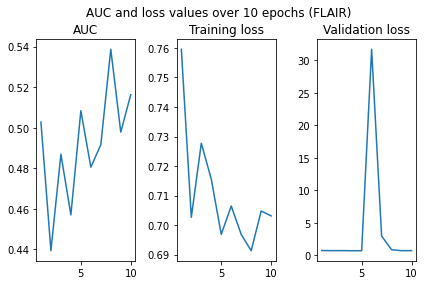

In [16]:
train_type = "FLAIR"
trained_model_path = train_model(train, valid, train_type)

In [17]:
def make_prediction(path, valid, mri_type, split):
    valid.loc[:,"MRI_Type"] = mri_type
    dataset = Dataset(
        valid.index.values,
        mri_type=mri_type,
        split=split
    )
    
    dataloader = torch.utils.data.DataLoader(
            dataset,
            batch_size=4,
            shuffle=False,
            num_workers=2
    )
    
    model = Model()
    model.to(device)
    model.load_state_dict(torch.load(path))
    model.eval()
    
    MGMT_prediction = []
    patient_ids = []
    
    for step, batch in enumerate(dataloader, 1):
        with torch.no_grad():
            prediction_sigmoid = torch.sigmoid(model(batch["X"].to(device))).cpu().numpy().squeeze()
            if prediction_sigmoid.size != 1:
                MGMT_prediction.extend(prediction_sigmoid.tolist())
            else:
                #if batch size happens to be 1
                MGMT_prediction.append(prediction_sigmoid)
            patient_ids.extend(batch["id"].numpy().tolist())
    
    prediction = pd.DataFrame({"BraTS21ID": patient_ids, "MGMT_value": MGMT_prediction}) 
    prediction = prediction.set_index("BraTS21ID")
    return prediction

In [18]:
valid.set_index("BraTS21ID", inplace=True)
valid.loc[:, "MGMT_prediction"] = 0.0
prediction = make_prediction(trained_model_path, valid, mri_type=train_type, split="train")

valid.loc[:,"MGMT_prediction"] += prediction.loc[:,"MGMT_value"]

auc = roc_auc_score(valid.loc[:, "MGMT_value"], valid.loc[:, "MGMT_prediction"])
print(f"Validation AUC: {auc}")

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Validation AUC: 0.538678712591756


/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


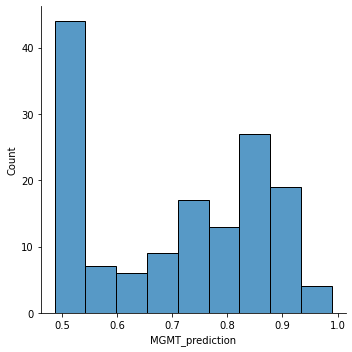

In [19]:
sns.displot(valid.loc[:, "MGMT_prediction"])

In [20]:
submission = pd.read_csv(f"/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/sample_submission.csv", index_col="BraTS21ID")

submission["MGMT_value"] = 0.0
prediction = make_prediction(trained_model_path, submission, train_type, split="test")
submission["MGMT_value"] += prediction["MGMT_value"]

submission["MGMT_value"].to_csv("submission.csv")

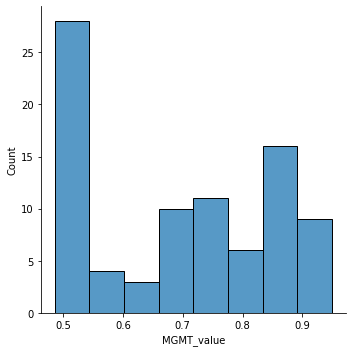

In [21]:
sns.displot(submission["MGMT_value"])

In [22]:
#model = Model()
#model.to(device)
#model.load_state_dict(torch.load(trained_model_path))

In [23]:
#img_3d = load_dicom_3d(1002, train_type)
#img_3d = torch.tensor(img_3d, dtype=torch.float64).unsqueeze(0).cuda()
#
#conv_weight = model.network._conv_stem.weight.cpu().detach().numpy()
#print(conv_weight.shape)
#plt.figure(figsize=(10, 10))
#for i in range(32):
#    plt.subplot(6, 6, i+1)
#    plt.imshow(conv_weight[i, 0, :, :, 2], cmap="gray")

In [24]:
#print(img_3d.shape)
#plt.imshow(img_3d[0, 0, :, :, 10].cpu().detach().numpy(), cmap="gray")

In [25]:
#net_modules = list(model.network.modules())
#conv_layers = []
#layer_weights = []
#conv_count = 0
#
#for module in net_modules:
#    if type(module) == Conv3dStaticSamePadding:
#        conv_layers.append(module)
#        layer_weights.append(module.weight)
#        
#output = []
#names = []
#image = img_3d
#
#for l in conv_layers:
#    names.append(str(l).split("(")[0])
#    image = l(image)
#    output.append(image)
#
#flattened_output = []
#for o in output:
#    o = o.squeeze(0)
#    grey_scale = torch.sum(o ,0)
#    grey_scale = grey_scale / o.shape[0]
#    flattened_output.append(grey_scale.cpu().detach().numpy())
#    
#fig = plt.figure(figsize=(30, 50))
#for i in range(len(flattened_output)):
#    sub_plot = fig.add_subplot(9, 9, i+1)
#    image = flattened_output[i]
#    imgplot = plt.imshow(image[:, :, 0])
#    sub_plot.axis("off")
#    sub_plot.set_title(names[i], fontsize=10)
#    